# 1. Исследование данных (Exploratory Data Analysis - EDA)

Этот ноутбук предназначен для загрузки, первичного анализа, проверки на пропуски, стационарность и визуализации базовых признаков для исторических данных акций AAPL.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from statsmodels.tsa.stattools import adfuller # Тест Дики-Фуллера

# Добавляем корневую директорию проекта в sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data_loader import load_stock_data

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 7)

## Загрузка данных

Загрузим данные для тикера AAPL с 2010 года.

In [2]:
ticker = 'AAPL'
start_date = '2010-01-01'

df_stock = load_stock_data(ticker=ticker, start_date=start_date)

if df_stock is None:
    raise ValueError(f'Не удалось загрузить данные для {ticker}. Ноутбук не может продолжить работу.')

print(f'Данные для {ticker} ({start_date} - {df_stock.index.max().strftime("%Y-%m-%d")}) успешно загружены.')

Загрузка данных для AAPL с 2010-01-01 по 2025-04-29...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Данные сохранены в data/raw\AAPL_2010-01-01_2025-04-29_raw.csv
Данные для AAPL (2010-01-01 - 2025-04-28) успешно загружены.


## Первичный осмотр данных

In [3]:
print("Первые 5 строк данных:")
display(df_stock.head())

print("Последние 5 строк данных:")
display(df_stock.tail())

print("Информация о DataFrame:")
# Используем display для лучшего форматирования вывода info в Jupyter
from io import StringIO
buffer = StringIO()
df_stock.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

print("Основные статистические показатели:")
display(df_stock.describe())

Первые 5 строк данных:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455076,6.391278,6.422876,493729600
2010-01-05,6.451466,6.487879,6.417460,6.458087,601904800
2010-01-06,6.348846,6.477045,6.342226,6.451466,552160000
2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
2010-01-08,6.379241,6.379844,6.291369,6.328684,447610800


Последние 5 строк данных:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-04-22,199.740005,201.589996,195.970001,196.119995,52976400
2025-04-23,204.600006,208.000000,202.800003,206.000000,52929200
2025-04-24,208.369995,208.830002,202.940002,204.889999,47311000
2025-04-25,209.279999,209.750000,206.199997,206.369995,38198600
2025-04-28,210.500504,211.500000,207.460007,210.059998,23246001


Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3853 entries, 2010-01-04 to 2025-04-28
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3853 non-null   float64
 1   (High, AAPL)    3853 non-null   float64
 2   (Low, AAPL)     3853 non-null   float64
 3   (Open, AAPL)    3853 non-null   float64
 4   (Volume, AAPL)  3853 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 180.6 KB

Основные статистические показатели:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,3853.000000,3853.000000,3853.000000,3853.000000,3.853000e+03
mean,70.729875,71.436077,69.949494,70.667396,2.264204e+08
std,68.653917,69.334825,67.880769,68.569106,2.172148e+08
min,5.779477,5.898345,5.725308,5.789106,2.323470e+07
25%,17.634253,17.853815,17.466533,17.681290,8.324240e+07
50%,36.363636,36.586685,36.019435,36.370672,1.372808e+08
75%,131.573395,133.013427,130.379927,132.003804,3.025904e+08
max,258.735504,259.814335,257.347047,257.906429,1.880998e+09


## Проверка на пропущенные значения

In [4]:
missing_values = df_stock.isnull().sum()
missing_percent = (missing_values / len(df_stock)) * 100
missing_table = pd.concat([missing_values, missing_percent], axis=1, keys=['Total Missing', 'Percent Missing (%)'])

print("Пропущенные значения по столбцам:")
display(missing_table[missing_table['Total Missing'] > 0])

if missing_table['Total Missing'].sum() == 0:
    print("Пропусков в данных не обнаружено.")
else:
    print("Обнаружены пропуски. Потребуется обработка (например, ffill). На данном этапе обработку не проводим, это будет сделано в скриптах препроцессинга.")

Пропущенные значения по столбцам:


,,Total Missing,Percent Missing (%)
Price,Ticker,,


Пропусков в данных не обнаружено.


## Визуализация данных

Построим графики цены закрытия и объема торгов, а также распределение цены закрытия.

In [9]:
# График цены закрытия
plt.figure(figsize=(15, 7))
plt.plot(df_stock.index, df_stock[('Price', 'Close')], label=f'{ticker} Close Price')
plt.title(f'Историческая цена закрытия {ticker}')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия (USD)')
plt.legend()
plt.show()

# График объема торгов
plt.figure(figsize=(15, 5))
plt.bar(df_stock.index, df_stock[('Price', 'Volume')], label=f'{ticker} Volume', color='grey')
plt.title(f'Объем торгов {ticker}')
plt.xlabel('Дата')
plt.ylabel('Объем')
plt.legend()
plt.show()

# Гистограмма и график плотности для цены закрытия
plt.figure(figsize=(10, 6))
sns.histplot(df_stock[('Price', 'Close')], kde=True, bins=50)
plt.title(f'Распределение цены закрытия {ticker}')
plt.xlabel('Цена закрытия (USD)')
plt.ylabel('Частота')
plt.show()

KeyError: ('Price', 'Close')

<Figure size 1500x700 with 0 Axes>

## Проверка на стационарность

Временной ряд стационарен, если его статистические свойства (среднее, дисперсия, автокорреляция) не изменяются со временем. Большинство моделей временных рядов (например, ARIMA) требуют стационарности данных.

Визуально ряд цены закрытия выглядит нестационарным (присутствует явный тренд). Проверим это формально с помощью **расширенного теста Дики-Фуллера (ADF)**.

- **Нулевая гипотеза (H0):** Ряд имеет единичный корень (нестационарен).
- **Альтернативная гипотеза (H1):** Ряд стационарен.

Если **p-value** теста меньше уровня значимости (например, 0.05), мы отвергаем H0 и считаем ряд стационарным. Если **p-value > 0.05**, мы не можем отвергнуть H0, и ряд, скорее всего, нестационарен.

Результаты теста Дики-Фуллера для "Close Price":
Test Statistic                    0.419533
p-value                           0.982211
#Lags Used                       30.000000
Number of Observations Used    3822.000000
Critical Value (1%)              -3.432062
Critical Value (5%)              -2.862297
Critical Value (10%)             -2.567173
dtype: float64

Вывод: p-value (0.9822) > 0.05. Не можем отвергнуть H0. Ряд "Close Price" вероятно нестационарен.
--------------------------------------------------
Результаты теста Дики-Фуллера для "First Difference of Close Price":
Test Statistic                -1.198559e+01
p-value                        3.619552e-22
#Lags Used                     3.000000e+01
Number of Observations Used    3.821000e+03
Critical Value (1%)           -3.432063e+00
Critical Value (5%)           -2.862297e+00
Critical Value (10%)          -2.567173e+00
dtype: float64

Вывод: p-value (0.0000) <= 0.05. Отвергаем H0. Ряд "First Difference of Close Price" вероятн

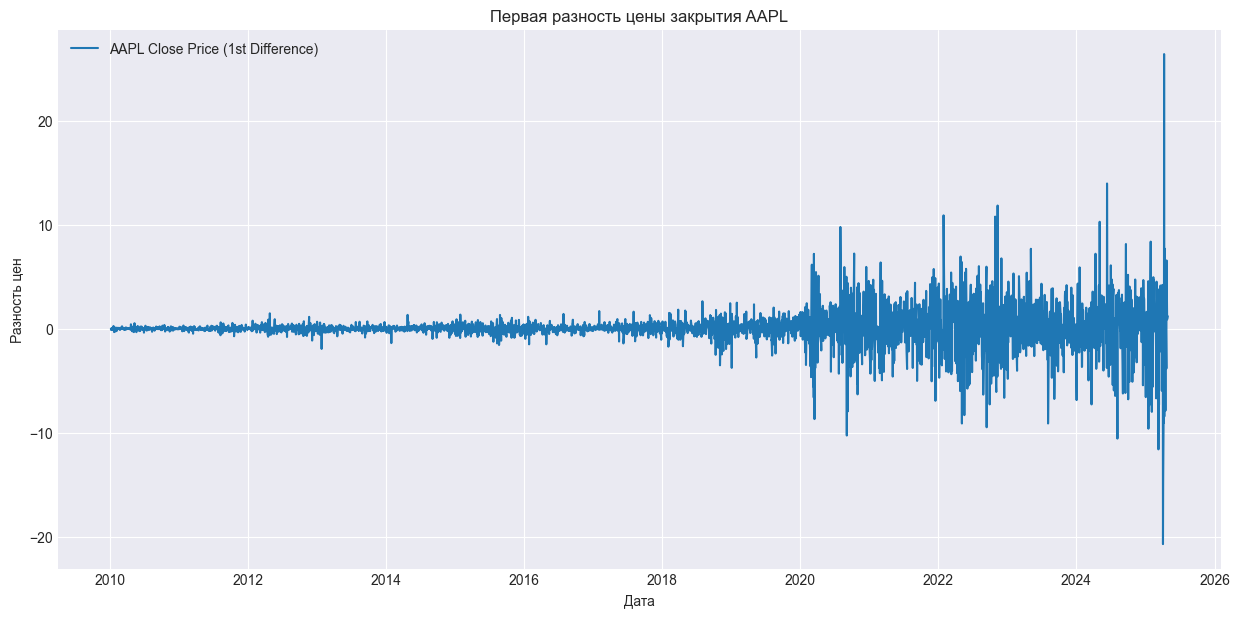

In [6]:
def perform_adf_test(series: pd.Series, series_name: str):
    """Выполняет тест ADF и выводит результаты."""
    print(f'Результаты теста Дики-Фуллера для "{series_name}":')
    # Удаляем пропуски, если они есть (важно после дифференцирования)
    dftest = adfuller(series.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput['p-value'] <= 0.05:
        print(f'\nВывод: p-value ({dfoutput['p-value']:.4f}) <= 0.05. Отвергаем H0. Ряд "{series_name}" вероятно стационарен.')
    else:
        print(f'\nВывод: p-value ({dfoutput['p-value']:.4f}) > 0.05. Не можем отвергнуть H0. Ряд "{series_name}" вероятно нестационарен.')
    print('-'*50)

# Тест для исходного ряда цены закрытия
perform_adf_test(df_stock['Close'], 'Close Price')

# Тест для ряда первых разностей (common way to achieve stationarity)
df_stock['Close_diff'] = df_stock['Close'].diff()
perform_adf_test(df_stock['Close_diff'], 'First Difference of Close Price')

# Визуализация первых разностей
plt.figure(figsize=(15, 7))
plt.plot(df_stock.index, df_stock['Close_diff'], label=f'{ticker} Close Price (1st Difference)'),
plt.title(f'Первая разность цены закрытия {ticker}')
plt.xlabel('Дата')
plt.ylabel('Разность цен')
plt.legend()
plt.show()

Как видно из теста, исходный ряд цены закрытия нестационарен (p-value >> 0.05), а ряд первых разностей уже стационарен (p-value близко к 0). Это типично для финансовых временных рядов.

## Визуализация скользящих средних

Скользящие средние (Moving Averages, MA) - популярный инструмент для сглаживания временных рядов и выявления трендов. Рассчитаем и построим 50-дневную (краткосрочный тренд) и 200-дневную (долгосрочный тренд) простые скользящие средние (SMA).

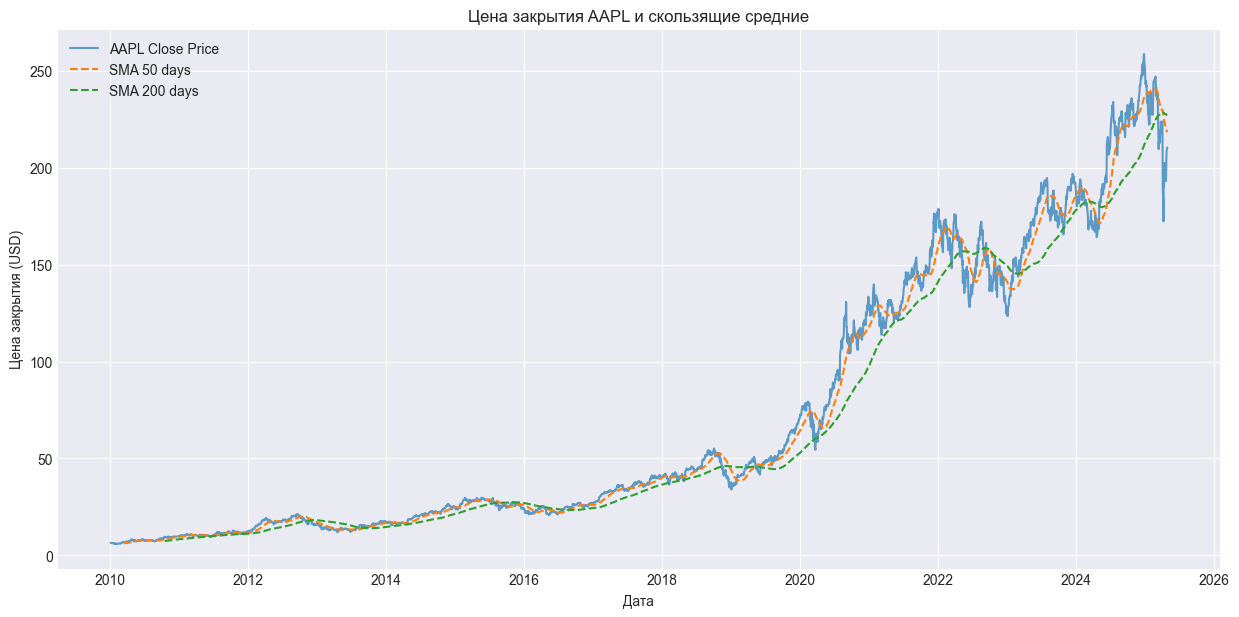

In [7]:
# Рассчет SMA
df_stock['SMA_50'] = df_stock['Close'].rolling(window=50).mean()
df_stock['SMA_200'] = df_stock['Close'].rolling(window=200).mean()

# Визуализация
plt.figure(figsize=(15, 7))
plt.plot(df_stock.index, df_stock['Close'], label=f'{ticker} Close Price', alpha=0.7)
plt.plot(df_stock.index, df_stock['SMA_50'], label='SMA 50 days', linestyle='--')
plt.plot(df_stock.index, df_stock['SMA_200'], label='SMA 200 days', linestyle='--')

plt.title(f'Цена закрытия {ticker} и скользящие средние')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия (USD)')
plt.legend()
plt.show()

## Завершение исследования

Первичный анализ данных завершен. Мы загрузили данные, проверили их на пропуски, визуализировали основные показатели, подтвердили нестационарность исходного ряда цен и стационарность ряда первых разностей, а также построили скользящие средние.